<a href="https://colab.research.google.com/github/rrfsantos/Segmentacao-de-Clientes-e-Predicao-de-Campanha-de-Marketing/blob/main/Classificacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!python -m pip install -U matplotlib
#!python -m pip install -U pandas

In [2]:
# Importando bibliotecas
import pandas as pd
import numpy as np
import re
import time
import datetime as dt
import itertools
import warnings
import seaborn as sns
import plotly.express as px
import matplotlib.ticker as mtick
import glob as glob
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from datetime import datetime

%matplotlib inline
warnings.filterwarnings('ignore')
np.random.seed(0)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

import os
workdir_path = '/content/drive/My Drive/iFood/'  # Inserir o local da pasta onde estão os arquivos de entrada (treino e teste)
os.chdir(workdir_path)

Mounted at /content/drive


### Pré processamento do Dataset para entrada nos modelos de Machine Learning

In [4]:
# Carregando dataset
data = pd.read_csv('ml_project1_data.csv', engine='python')

In [5]:
# Substituindo valores nulos na coluna 'Income' pela mediana - A base é muito pequena, melhor não deletar linhas
df = data.copy()
median_value = df.Income.median()
df.Income.fillna(value = median_value, inplace=True)

In [6]:
# Removendo as colunas Z_CostContact e Z_Revenue
df.drop(columns=['ID', 'Z_CostContact',	'Z_Revenue'], inplace=True)

In [7]:
# Tranformando a coluna Dt_Customer em número de dias (data fim 2015-01-01)
end_date = datetime.strptime('2015-01-01', '%Y-%m-%d')
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%Y.%m.%d')

days = lambda x: int((end_date - x).days)
df.Dt_Customer = df.Dt_Customer.apply(days)

In [8]:
# Substituindo 'Alone', 'Absurd' e 'YOLO' por 'Single'
single = lambda x: re.sub(r'Alone|Absurd|YOLO', 'Single', x)
df.Marital_Status = df.Marital_Status.apply(single)

In [9]:
# Substituindo ano menor que 1920 na coluna 'Year_Birth' pela mediana
median_value = df.Year_Birth.median()
mask = df.Year_Birth < 1920
column_name = 'Year_Birth'
df.loc[mask, column_name] = median_value

In [10]:
# Removendo renda maior que 100k - Estava interferindo na construção dos clusters
df.drop(df[df.Income > 100000].index, inplace=True)

In [11]:
# Substituindo features correlacionadas por sua média
column = df.loc[: , 'MntWines':'MntGoldProds']
df['MntProducts'] = column.mean(axis=1)
df.drop(columns=['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts','MntGoldProds'], inplace=True)

In [12]:
# Substituindo features correlacionadas por sua média
column = df.loc[: , 'AcceptedCmp3':'AcceptedCmp2']
df['AcceptedCmp'] = column.mean(axis=1)
df.drop(columns=['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5','AcceptedCmp1', 'AcceptedCmp2'], inplace=True)

In [13]:
# Transformando variáveis não numéricas em numéricas
le_e = LabelEncoder()
df['Education'] = le_e.fit_transform(df['Education'])

le_m = LabelEncoder()
df['Marital_Status']  = le_m.fit_transform(df['Marital_Status'])

In [14]:
# Normalizando os dados
df_norm = df.iloc[:, 1:]
df_c = pd.DataFrame(df.Response, columns=['Response'])
std_scaler = StandardScaler()
scaler = std_scaler.fit_transform(df_norm)
df_normalized = pd.DataFrame(scaler)

df = pd.concat([df_c.reset_index(), df_normalized.reset_index()], axis = 1, sort=False)
df.drop(columns=['index'], inplace=True)

In [15]:
# Balanceando o dataset - upsample
print('Antes:', df.shape)

df_1 = df[df['Response'] == 1]
df_0 = df[df['Response'] == 0]  
df_1_upsampled = resample(df_1, n_samples=len(df_0), replace=True)
df = pd.concat([df_1_upsampled,df_0])

print('Depois:', df.shape)

Antes: (2227, 17)
Depois: (3794, 17)


## Previsão de adesão à campanha

In [16]:
# Dividindo a base em treino e teste
df['Response'] = df['Response'].astype('category')
X = df.loc[:, df.columns != 'Response']
y = df.Response

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

### Random Forest

In [17]:
# Random Forest
begin_time = dt.datetime.now()

random_forest = RandomForestClassifier(n_estimators=150, min_samples_leaf=3, max_features=0.5, n_jobs=-1)
random_forest.fit(X_train, y_train)

random_forest.score(X_train, y_train)
acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)
print('Acurácia do modelo RandomForestClassifier:', acc_random_forest,"\n")

y_pred1 = random_forest.predict(X_test)

# Matrix de Confusão
print(pd.crosstab(y_test, y_pred1, rownames=["Real"], colnames=["Predict"], margins=True), '\n')

report = (classification_report(y_test, y_pred1, output_dict=True))
df_class_report = pd.DataFrame(report).transpose()
df_class_report.to_csv('/content/drive/MyDrive/iFood/report/random_forest.csv', encoding='utf-8')

time_rf = (dt.datetime.now() - begin_time)

Acurácia do modelo RandomForestClassifier: 100.0 

Predict    0    1  All
Real                  
0        393    0  393
1          0  366  366
All      393  366  759 



### Decision Tree

In [18]:
# Decision Tree
begin_time = dt.datetime.now()

decision_tree = DecisionTreeClassifier(max_depth = 16)
decision_tree.fit(X_train, y_train)

y_pred2 = decision_tree.predict(X_test)

acc_decision_tree = round(decision_tree.score(X_train, y_train) * 100, 2)
print('Acurácia do modelo DecisionTreeClassifier:',acc_decision_tree, "\n")

# Matrix de Confusão
print(pd.crosstab(y_test, y_pred2, rownames=["Real"], colnames=["Predict"], margins=True))

# Classification Report
report = (classification_report(y_test, y_pred2, output_dict=True))
df_class_report = pd.DataFrame(report).transpose()
df_class_report.to_csv('/content/drive/MyDrive/iFood/report/decision_tree.csv', encoding='utf-8')

time_d3 = (dt.datetime.now() - begin_time)

Acurácia do modelo DecisionTreeClassifier: 100.0 

Predict    0    1  All
Real                  
0        393    0  393
1          0  366  366
All      393  366  759


### KNN

In [19]:
# KNN
begin_time = dt.datetime.now()

knn = KNeighborsClassifier(n_neighbors = 3, weights= 'distance')
knn.fit(X_train, y_train)

y_pred3 = knn.predict(X_test)

acc_knn = round(knn.score(X_train, y_train) * 100, 2)
print('Acurácia do modelo KNeighborsClassifier:',acc_knn, "\n")

# Matrix de Confusão
print(pd.crosstab(y_test, y_pred3, rownames=["Real"], colnames=["Predict"], margins=True))

# Classification Report
report = (classification_report(y_test, y_pred3, output_dict=True))
df_class_report = pd.DataFrame(report).transpose()
df_class_report.to_csv('/content/drive/MyDrive/iFood/report/knn.csv', encoding='utf-8')


time_knn = (dt.datetime.now() - begin_time)

Acurácia do modelo KNeighborsClassifier: 100.0 

Predict    0    1  All
Real                  
0        392    1  393
1          0  366  366
All      392  367  759


### Logistic Regression

In [20]:
# Logistic Regression
begin_time = dt.datetime.now()

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

acc_log = round(logreg.score(X_train, y_train) * 100, 2)
print('Acurácia do modelo LogisticRegression:',acc_log, "\n")

y_pred4 = logreg.predict(X_test)

# Matrix de Confusão
print(pd.crosstab(y_test,y_pred4, rownames=["Real"], colnames=["Predict"], margins=True))

# Classification Report
report = (classification_report(y_test, y_pred4, output_dict=True))
df_class_report = pd.DataFrame(report).transpose()
df_class_report.to_csv('/content/drive/MyDrive/iFood/report/log_reg.csv', encoding='utf-8')

time_lg = (dt.datetime.now() - begin_time)

Acurácia do modelo LogisticRegression: 100.0 

Predict    0    1  All
Real                  
0        393    0  393
1          0  366  366
All      393  366  759


In [21]:
# Tempo de processamento de cada modelo
results = pd.DataFrame({
    'Model': ['Random Forest','KNN','Decision Tree','Logistic Regression'],
    'Time': [time_rf, time_d3, time_knn, time_knn]})
    
result_df = results.sort_values(by='Time', ascending=True)
result_df = result_df.set_index('Time')
result_df.head(9)

,Model
Time,
0 days 00:00:00.193699,KNN
0 days 00:00:00.621868,Decision Tree
0 days 00:00:00.621868,Logistic Regression
0 days 00:00:01.210408,Random Forest


## Métricas de Avaliação

In [22]:
reports = glob.glob('/content/drive/MyDrive/iFood/report/*.csv')

In [23]:
df_metrica = pd.DataFrame()
acc = []
report_name = []
for i in range(len(reports)):
    base = os.path.basename(reports[i])
    report_name.append(os.path.splitext(base)[0])
    d = pd.read_csv(reports[i]).T
    new_header = d.iloc[0]
    d = d[1:]
    d.columns = new_header
    acc.append(list(np.unique(d.accuracy.astype(float))))
    d.set_axis(['precision', 'recall', 'f1-score', 'support'], axis=0, inplace=True)
    df_metrica = df_metrica.append(d) 
df_metrica['metrica'] = df_metrica.index

In [24]:
acc = list(itertools.chain.from_iterable(acc))

### Acurária para cada Modelo

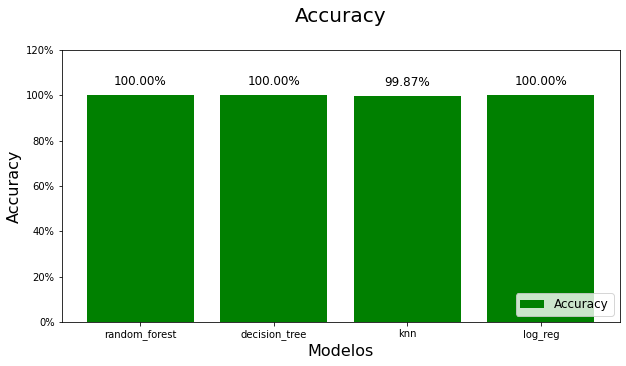

In [25]:
figure(figsize=(10, 5))
ax = plt.axes()
ax.bar(report_name, acc, label='Accuracy', color='g')
for x,y in zip(report_name, acc):
    label = "{:.2%}".format(y)
    plt.annotate(label, (x,y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=12)

plt.xticks(report_name)
plt.ylim(0.5,1)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))

plt.legend(loc='lower right', fontsize = 12)
plt.xlabel('Modelos', fontsize = 16)
plt.ylabel('Accuracy', fontsize = 16)
plt.title('Accuracy\n', fontsize = 20)
plt.ylim(0, 1.2)
plt.show();

### Precisão para cada Modelo

In [26]:
df_metrica.columns = df_metrica.columns.astype(str)
df_metrica = df_metrica.rename(columns={'0': 'No', '1': 'Yes'})
df_precision = df_metrica[df_metrica['metrica']=='precision']

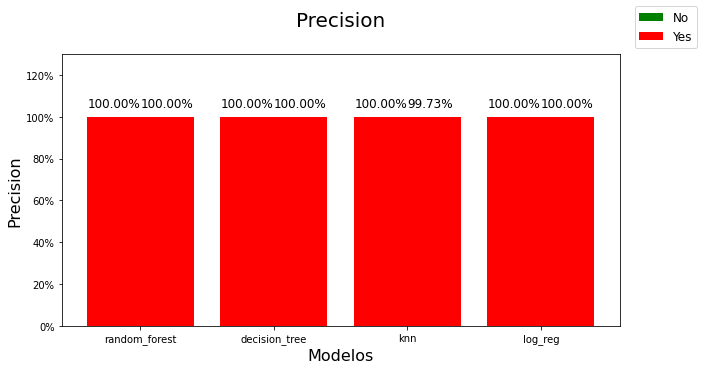

In [27]:
no = df_precision['No']
yes = df_precision['Yes']

figure(figsize=(10, 5))
ax = plt.axes()

ax.bar(report_name, no, label='No', color='g')
for x,y in zip(report_name, no):
    label = "{:.2%}".format(y)
    plt.annotate(label, (x,y), textcoords="offset points", xytext=(0,10), ha='right', fontsize=12) 

ax.bar(report_name, yes, label='Yes', color='r')
for x,y in zip(report_name, yes):
    label = "{:.2%}".format(y)
    plt.annotate(label, (x,y), textcoords="offset points", xytext=(0,10), ha='left', fontsize=12)

plt.xticks(report_name)
plt.ylim(0.5,1)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))

plt.legend(loc='lower right', bbox_to_anchor=(1.15, 1), fontsize=12)
plt.xlabel('Modelos', fontsize = 16)
plt.ylabel('Precision', fontsize = 16)
plt.title('Precision\n', fontsize = 20)
plt.ylim(0, 1.3)
plt.show();

### Recall para cada Modelo

In [28]:
df_recall = df_metrica[df_metrica['metrica']=='recall']

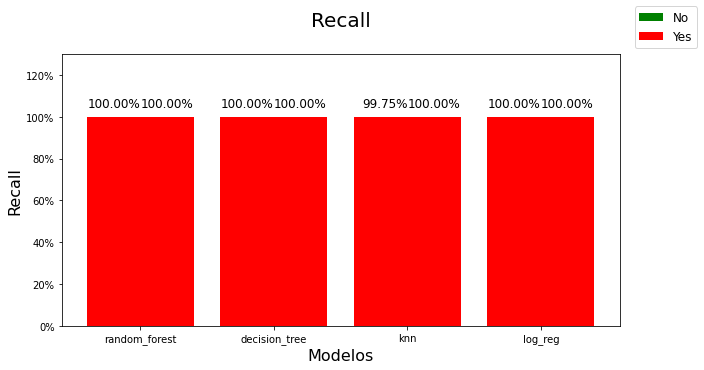

In [29]:
no = df_recall['No']
yes = df_recall['Yes']

figure(figsize=(10, 5))

ax = plt.axes()

ax.bar(report_name, no, label='No', color='g')
for x,y in zip(report_name, no):
    label = "{:.2%}".format(y)
    plt.annotate(label, (x,y), textcoords="offset points", xytext=(0,10), ha='right', fontsize=12) 

ax.bar(report_name, yes, label='Yes', color='r')
for x,y in zip(report_name, yes):
    label = "{:.2%}".format(y)
    plt.annotate(label, (x,y), textcoords="offset points", xytext=(0,10), ha='left', fontsize=12)
  
plt.xticks(report_name)
plt.ylim(0.5,1)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))

plt.legend(loc='lower right', bbox_to_anchor=(1.15, 1), fontsize=12)
plt.xlabel('Modelos', fontsize = 16)
plt.ylabel('Recall', fontsize = 16)
plt.title('Recall\n', fontsize = 20)
plt.ylim(0, 1.3)
plt.show();